<a href="https://colab.research.google.com/github/chemsou-lmc/phishing-urls-classification/blob/main/phishing_websites_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import the libraries**

In [66]:
import pandas as pd
import numpy as np

import re
import string

from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import vstack
from scipy.sparse import hstack

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import roc_curve,plot_roc_curve, auc


import matplotlib.pyplot as plt
import seaborn as sns

### **Read the dataset**

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Projects/phishing_websites_dataset.csv')

In [3]:
df.head(5)

,domain,ranking,isIp,valid,activeDuration,urlLen,is@,isredirect,haveDash,domainLen,nosOfSubdomain,label
0,www.voting-yahoo.com,10000000,0,0,0,20,0,0,1,20,2,1
1,www.zvon.org/xxl/WSDL1.1/Output/index.html,194914,0,1,7305,42,0,0,0,12,2,0
2,tecportais.com/file-security-update-infonfmati...,10000000,0,0,0,155,0,0,0,14,1,1
3,bima.astro.umd.edu/nemo/linuxastro/,7001,0,0,0,35,0,0,0,18,3,0
4,huarui-tec.com/js/?us.battle.net/login/en/?ref...,10000000,0,1,730,79,0,0,1,14,1,1


In [4]:
df.tail(5)

,domain,ranking,isIp,valid,activeDuration,urlLen,is@,isredirect,haveDash,domainLen,nosOfSubdomain,label
95905,www.freewebs.com/ryanrules2/,5001,0,1,8035,28,0,0,0,16,2,0
95906,www.ireland-information.com/freecelticfonts.htm,230251,0,1,8400,47,0,0,1,27,2,0
95907,www.clubtaunus.soroptimist.de/img/pro/e.php,10000000,0,0,0,43,0,0,0,29,3,1
95908,www.askmen.com/sports/business/index.html,2008,0,1,9862,41,0,0,0,14,2,0
95909,xosothudo.com.vn/paypal.co.il/paypal.co.il.cgi...,771840,0,0,0,323,0,0,0,16,2,1


In [5]:
df.columns

Index(['domain', 'ranking', 'isIp', 'valid', 'activeDuration', 'urlLen', 'is@',
       'isredirect', 'haveDash', 'domainLen', 'nosOfSubdomain', 'label'],
      dtype='object')

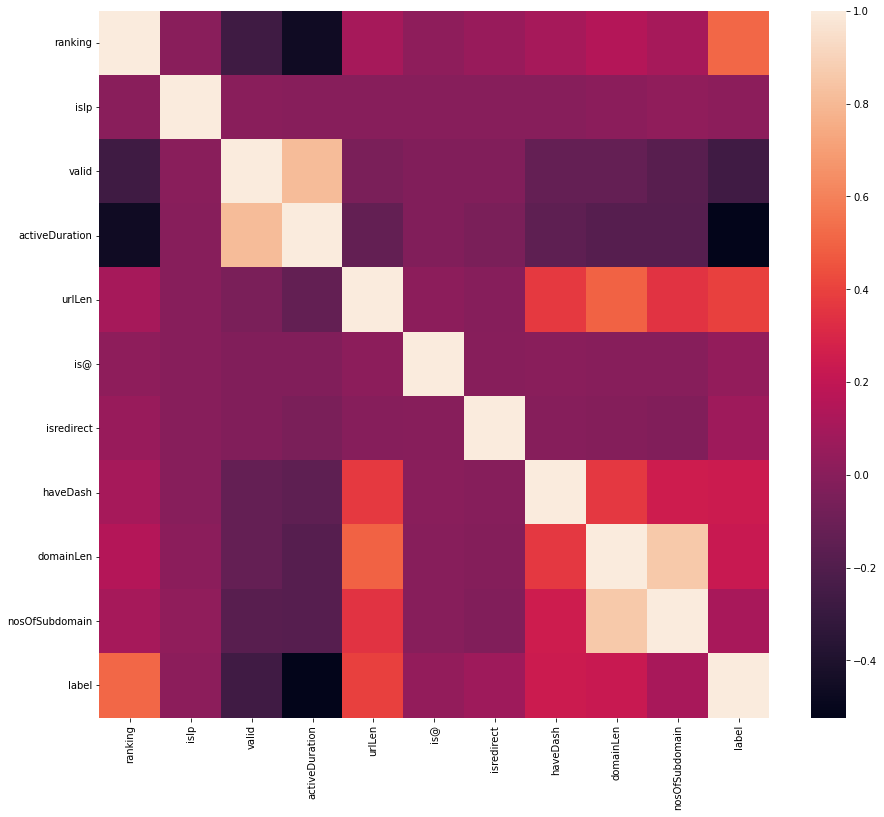

In [6]:
plt.figure(figsize=(15,13))
sns.heatmap(df.corr())
plt.show()

In [7]:
#Checking for null values
df.isna().any()

domain            False
ranking           False
isIp              False
valid             False
activeDuration    False
urlLen            False
is@               False
isredirect        False
haveDash          False
domainLen         False
nosOfSubdomain    False
label             False
dtype: bool

# **the distribution of dataset**

In [8]:
print(df['label'].value_counts())
print(df.shape)

1    55914
0    39996
Name: label, dtype: int64
(95910, 12)


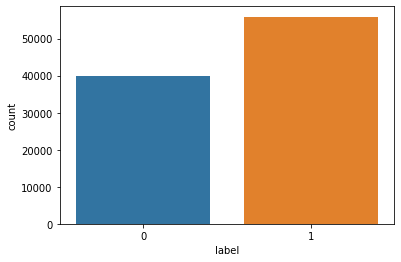

In [9]:
sns.countplot(data=df, x="label")
plt.show()

In [10]:
df_x = df.drop(['label'], axis=1)
df_y = df['label']

### **FEATURE SELECTION**

In [11]:
#Dividing the dataset into training( 60%) and testing (40%) sets

train_df_x = df_x[:57546]
train_df_y = df_y[:57546]

test_df_x = df_x[38364:]
test_df_y = df_y[38364:]

val_df_x = df_x[38364:57546]
val_df_y = df_y[38364:57546]

In [12]:
train_domain = train_df_x['domain']
val_domain = val_df_x['domain']
test_domain = test_df_x['domain']

In [13]:
#Drop 'domain' from dataset since we are converting it into bag of words

train_df_x = train_df_x.drop(['domain'], axis=1)
val_df_x = val_df_x.drop(['domain'], axis=1)
test_df_x = test_df_x.drop(['domain'], axis=1)

In [14]:
print(train_df_x.shape, val_df_x.shape, test_df_x.shape)
print(train_df_y.shape, val_df_y.shape, test_df_y.shape)

(57546, 10) (19182, 10) (57546, 10)
(57546,) (19182,) (57546,)


### **FEATURE EXTRACTION**

In [15]:
count_vect = CountVectorizer()
X_train_bow = count_vect.fit_transform(train_domain)
X_val_bow = count_vect.transform(val_domain)
X_test_bow = count_vect.transform(test_domain)
feature_names_bow = count_vect.get_feature_names()
print(X_train_bow.shape)
print(X_val_bow.shape)
print(X_test_bow.shape)

(57546, 72611)
(19182, 72611)
(57546, 72611)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [16]:
#Stacking the BoW features and other features from dataset

bow_final_train_x = hstack((X_train_bow, train_df_x))
bow_final_val_x = hstack((X_val_bow, val_df_x))
bow_final_test_x = hstack((X_test_bow, test_df_x))

In [17]:

bow_final_train_x.shape
bow_final_val_x.shape
bow_final_test_x.shape

(57546, 72621)

In [18]:
X_train_val = vstack((bow_final_train_x, bow_final_val_x))
Y_train_val = pd.concat([train_df_y, val_df_y], axis= 0)

## **MODELS & TRAINING**

In [19]:
scoring = {'accuracy': 'accuracy',
           'recall': 'recall',
           'precision': 'precision',
           'f1': 'f1'}
fold_count=10

In [20]:
def mean_score(scoring):
    return {i:j.mean() for i,j in scoring.items()}

# **1-Logistic Regression**

In [21]:
logreg=LogisticRegression()
model_1=logreg.fit(X_train_val,Y_train_val)

In [22]:
logreg_predict= model_1.predict(bow_final_test_x)

In [45]:
print('The accuracy of Logistic Regression Model is : ', 100.0 * accuracy_score(logreg_predict,test_df_y))

The accuracy of Logistic Regression Model is :  72.54022868661593


In [24]:
print(classification_report(logreg_predict,test_df_y))

              precision    recall  f1-score   support

           0       0.55      0.72      0.62     18140
           1       0.85      0.73      0.78     39406

    accuracy                           0.73     57546
   macro avg       0.70      0.72      0.70     57546
weighted avg       0.76      0.73      0.73     57546



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


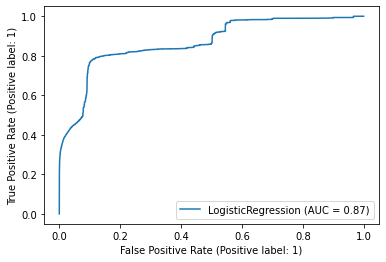

In [60]:
plot_roc_curve(model_1,bow_final_test_x, test_df_y)

# **2-KNN**

In [25]:
knn=KNeighborsClassifier(n_neighbors=1)
model_2= knn.fit(X_train_val,Y_train_val)

In [26]:
knn_predict=model_2.predict(bow_final_test_x)

In [28]:
print('The accuracy of KNN Model is: ', 100.0 * accuracy_score(knn_predict,test_df_y))

The accuracy of KNN Model is:  97.25263267646753


In [30]:
print(classification_report(test_df_y,knn_predict))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     23920
           1       0.98      0.98      0.98     33626

    accuracy                           0.97     57546
   macro avg       0.97      0.97      0.97     57546
weighted avg       0.97      0.97      0.97     57546



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


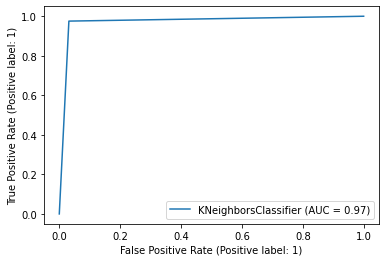

In [61]:
plot_roc_curve(model_2,bow_final_test_x, test_df_y)

# **3-Decision Tree Classifier**

In [31]:
dtree=DecisionTreeClassifier()
model_3=dtree.fit(X_train_val,Y_train_val)

In [32]:
dtree_predict=model_3.predict(bow_final_test_x)

In [34]:
print('The accuracy of Decision Tree Classifier is: ', 100.0 * accuracy_score(dtree_predict,test_df_y))

The accuracy of Decision Tree Classifier is:  98.24662009522817


In [36]:
print(classification_report(dtree_predict,test_df_y))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     23903
           1       0.99      0.98      0.99     33643

    accuracy                           0.98     57546
   macro avg       0.98      0.98      0.98     57546
weighted avg       0.98      0.98      0.98     57546



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


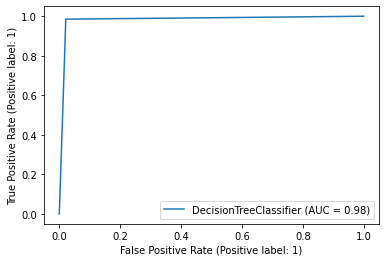

In [62]:
plot_roc_curve(model_3,bow_final_test_x, test_df_y)

# **4-Random forest Classifier**

In [37]:

rfc=RandomForestClassifier()
model_4=rfc.fit(X_train_val,Y_train_val)

In [38]:
rfc_predict=model_4.predict(bow_final_test_x)

In [40]:
print('The accuracy of Random Forest Classifier is: ' , 100.0 * accuracy_score(rfc_predict,test_df_y))

The accuracy of Random Forest Classifier is:  99.0772599311855


In [39]:
print(classification_report(rfc_predict,test_df_y))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23919
           1       0.99      0.99      0.99     33627

    accuracy                           0.99     57546
   macro avg       0.99      0.99      0.99     57546
weighted avg       0.99      0.99      0.99     57546



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


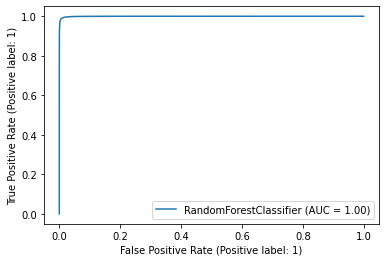

In [63]:
plot_roc_curve(model_4,bow_final_test_x, test_df_y)

# **5-SVM**

In [41]:
svc=SVC()
model_5=svc.fit(X_train_val,Y_train_val)

In [42]:
svm_predict=model_5.predict(bow_final_test_x)

In [43]:
print('The accuracy of SVM Classifier is: ', 100.0 * accuracy_score(svm_predict,test_df_y))

The accuracy of SVM Classifier is:  76.70211656761548


In [44]:
print(classification_report(svm_predict,test_df_y))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71     22609
           1       0.82      0.79      0.80     34937

    accuracy                           0.77     57546
   macro avg       0.76      0.76      0.76     57546
weighted avg       0.77      0.77      0.77     57546



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


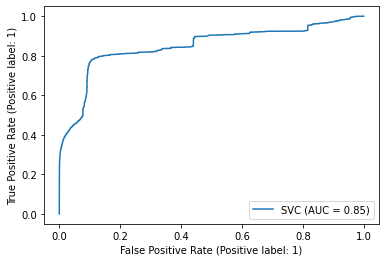

In [64]:
plot_roc_curve(model_5,bow_final_test_x, test_df_y)

# **Evaluation**

In [47]:
print('Logistic Regression Accuracy:',100 * accuracy_score(logreg_predict,test_df_y))
print('K-Nearest Neighbour Accuracy:',100* accuracy_score(knn_predict,test_df_y))
print('Decision Tree Classifier Accuracy:',100* accuracy_score(dtree_predict,test_df_y))
print('Random Forest Classifier Accuracy:',100*accuracy_score(rfc_predict,test_df_y))
print('support Vector Machine Accuracy:',100*accuracy_score(svm_predict,test_df_y))


Logistic Regression Accuracy: 72.54022868661593
K-Nearest Neighbour Accuracy: 97.25263267646753
Decision Tree Classifier Accuracy: 98.24662009522817
Random Forest Classifier Accuracy: 99.0772599311855
support Vector Machine Accuracy: 76.70211656761548
